In [285]:
#pip install yellowbrick --upgrade

In [286]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import impute
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from google.colab import files
import io 
import copy

In [287]:
# Load data :
data_to_load = files.upload()
df=pd.read_excel('SuveyWimbox113.xlsx')
print(df.keys())

Saving SuveyWimbox113.xlsx to SuveyWimbox113 (1).xlsx
Index(['Gender', 'Sexuality', 'Age', 'Job', 'IR', 'SA', 'SF', 'CM', 'PVM',
       'PCM', 'PVPM', 'KM', 'GKM', 'Confidence', 'IP', 'WB', 'WNB', 'WP',
       'HWB', 'FQ'],
      dtype='object')


## Data Exploration

In [288]:
# create target and data:
X=df.drop(['IP','WB','WNB','WP','HWB','FQ'], axis=1) #data
y=df['IP'] #target

In [289]:
X.columns

Index(['Gender', 'Sexuality', 'Age', 'Job', 'IR', 'SA', 'SF', 'CM', 'PVM',
       'PCM', 'PVPM', 'KM', 'GKM', 'Confidence'],
      dtype='object')

In [290]:
X.shape

(113, 14)

In [291]:
X.head()

Gender Sexuality  Age                              Job   IR   SA       SF  \
0  Woman  straight   20     Engineering or manufacturing   No  Yes   Weekly   
1    Man  straight   22                          Student  Yes  Yes   Weekly   
2    Man  straight   22                          Student  Yes  Yes   Weekly   
3  Woman  bisexual   33  Accountancy, banking or finance  Yes  Yes  Monthly   
4    Man  straight   24       Science or pharmaceuticals  Yes  Yes   Weekly   

          CM            PVM        PCM PVPM   KM  GKM  \
0  oral pill            Yes     condom  yes  Yes    2   
1       none  not concerned  oral pill  yes  Yes    2   
2     condom            Yes       none  yes   No    2   
3  oral pill             No       none  yes   No    2   
4       none  not concerned        IUD   No  Yes    4   

                         Confidence  
0                                No  
1  I don’t yet know enough about it  
2                                No  
3  I don’t yet know enough about it  
4                               Yes

In [292]:
X.tail()

Gender Sexuality  Age      Job   IR   SA      SF      CM            PVM  \
108    Man  straight   24  Student  Yes   No   other    none  not concerned   
109    Man  straight   23  Student  Yes  Yes   Daily    none  not concerned   
110    Man     other   19  Student   No  Yes   other  condom            Yes   
111  Woman  straight   20  Student  Yes  Yes  Weekly    none  not concerned   
112    Man  bisexual   23  Student  Yes  Yes  Weekly  condom            Yes   

           PCM           PVPM   KM  GKM                        Confidence  
108       none  not concerned  Yes    4  I don’t yet know enough about it  
109  oral pill             No  Yes    4                                No  
110       none  not concerned  Yes    3                               Yes  
111     condom  not concerned  Yes    1  I don’t yet know enough about it  
112       none            yes  Yes    5                               Yes

In [293]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Gender      113 non-null    object
 1   Sexuality   113 non-null    object
 2   Age         113 non-null    int64 
 3   Job         113 non-null    object
 4   IR          113 non-null    object
 5   SA          113 non-null    object
 6   SF          113 non-null    object
 7   CM          113 non-null    object
 8   PVM         113 non-null    object
 9   PCM         113 non-null    object
 10  PVPM        113 non-null    object
 11  KM          113 non-null    object
 12  GKM         113 non-null    int64 
 13  Confidence  113 non-null    object
dtypes: int64(2), object(12)
memory usage: 12.5+ KB


In [294]:
X.describe()

Age         GKM
count  113.000000  113.000000
mean    24.451327    2.690265
std      6.526035    1.165575
min     19.000000    1.000000
25%     21.000000    2.000000
50%     22.000000    3.000000
75%     24.000000    4.000000
max     54.000000    5.000000

# Preprocess data

Categorize to Numerical

In [295]:

X.IR = X.IR.astype("category").cat.codes # Yes = 1, No =0
X.SA = X.SA.astype("category").cat.codes # Yes = 1, No =0
X['SF'] = X['SF'].apply(lambda x:0 if x == 'Daily' else(1 if x=='Weekly' else (2 if x=='Monthly' else 3)))
X.PVM = X.PVM.astype("category").cat.codes # Yes = 2 , not concerned =1, No =0
X.PVPM = X.PVPM.astype("category").cat.codes # Yes = 2 , not concerned =1, No =0
X.KM = X.KM.astype("category").cat.codes # Yes = 1, No =0
X.Confidence = X.Confidence.apply(lambda x:0 if x == 'No' else(2 if x=='Yes' else 1))


In [296]:
X.Gender = X.Gender.apply(lambda x:'Gender_other' if x== 'Other' else(x))
X.Sexuality = X.Sexuality.apply(lambda x:'Sexuality_other' if x== 'other' else(x))
X.Job = X.Job.apply(lambda x:'Job_other' if(x!= 'Computing or IT' and x!= 'Engineering or manufacturing'and x!= 'Teacher training or education' and x!= 'Student') else(x))
X['CM'] = X['CM'].apply(lambda x:'CM_other' if (x!= 'condom' and x!= 'oral pill'and x!= 'IUD' and x!= 'none') else(x))
X.PCM = X.PCM.apply(lambda x:'PCM_condom' if x== 'condom' else( 'PCM_oral pill' if x== 'oral pill' else ( 'PCM_IUD' if x=='IUD' else( 'PCM_none' if x == 'none' else('PCM_other')))))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f61951b3d50>,
      dtype=object)

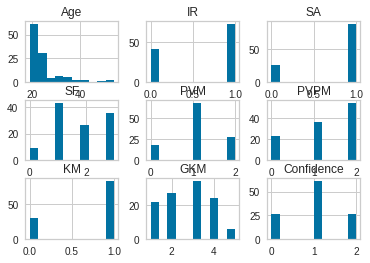

In [297]:
X.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6194f14790>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

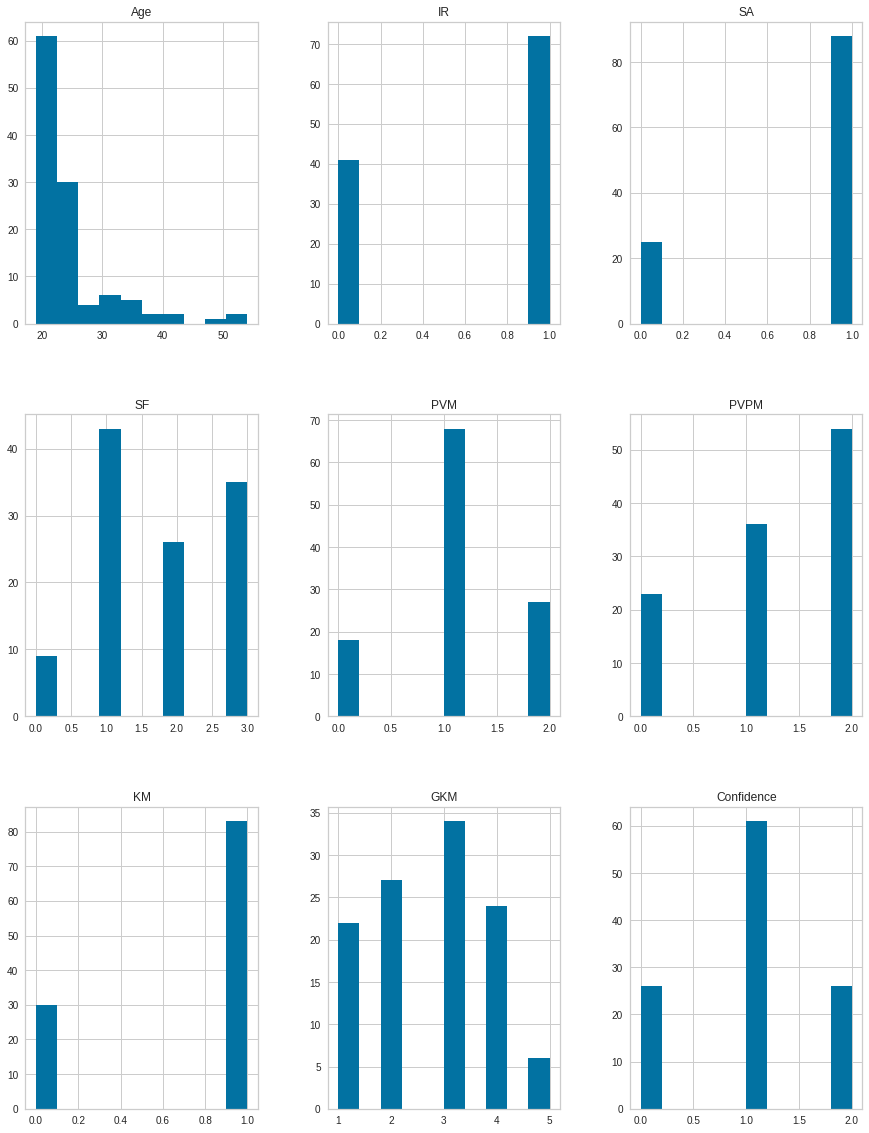

In [298]:
plt.clf()
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
X.hist(ax = ax)

In [299]:
X.head()

Gender Sexuality  Age                           Job  IR  SA  SF         CM  \
0  Woman  straight   20  Engineering or manufacturing   0   1   1  oral pill   
1    Man  straight   22                       Student   1   1   1       none   
2    Man  straight   22                       Student   1   1   1     condom   
3  Woman  bisexual   33                     Job_other   1   1   2  oral pill   
4    Man  straight   24                     Job_other   1   1   1       none   

   PVM            PCM  PVPM  KM  GKM  Confidence  
0    1     PCM_condom     2   1    2           0  
1    2  PCM_oral pill     2   1    2           1  
2    1       PCM_none     2   0    2           0  
3    0       PCM_none     2   0    2           1  
4    2        PCM_IUD     0   1    4           2

In [300]:
encoder=preprocessing.OneHotEncoder(handle_unknown='ignore')
X1=pd.DataFrame(encoder.fit_transform(X[['Gender']]).toarray(),columns=encoder.categories_[0].tolist())
X1=pd.concat([X.reset_index(),X1],axis=1)
X1=X1.drop(['Gender','index'],axis=1)
X1.head().T

0              1  \
Sexuality                                      straight       straight   
Age                                                  20             22   
Job                        Engineering or manufacturing        Student   
IR                                                    0              1   
SA                                                    1              1   
SF                                                    1              1   
CM                                            oral pill           none   
PVM                                                   1              2   
PCM                                          PCM_condom  PCM_oral pill   
PVPM                                                  2              2   
KM                                                    1              1   
GKM                                                   2              2   
Confidence                                            0              1   
Gender_other                                        0.0            0.0   
Man                                                 0.0            1.0   
Non-Binary/Non-Conforming                           0.0            0.0   
Woman                                               1.0            0.0   

                                  2          3          4  
Sexuality                  straight   bisexual   straight  
Age                              22         33         24  
Job                         Student  Job_other  Job_other  
IR                                1          1          1  
SA                                1          1          1  
SF                                1          2          1  
CM                           condom  oral pill       none  
PVM                               1          0          2  
PCM                        PCM_none   PCM_none    PCM_IUD  
PVPM                              2          2          0  
KM                                0          0          1  
GKM                               2          2          4  
Confidence                        0          1          2  
Gender_other                    0.0        0.0        0.0  
Man                             1.0        0.0        1.0  
Non-Binary/Non-Conforming       0.0        0.0        0.0  
Woman                           0.0        1.0        0.0

In [301]:
encoder=preprocessing.OneHotEncoder(handle_unknown='ignore')
X2=pd.DataFrame(encoder.fit_transform(X1[['Sexuality']]).toarray(),columns=encoder.categories_[0].tolist())
X2=pd.concat([X1.reset_index(),X2],axis=1)
X2=X2.drop(['Sexuality','index'],axis=1)
X2.head().T

0              1  \
Age                                                  20             22   
Job                        Engineering or manufacturing        Student   
IR                                                    0              1   
SA                                                    1              1   
SF                                                    1              1   
CM                                            oral pill           none   
PVM                                                   1              2   
PCM                                          PCM_condom  PCM_oral pill   
PVPM                                                  2              2   
KM                                                    1              1   
GKM                                                   2              2   
Confidence                                            0              1   
Gender_other                                        0.0            0.0   
Man                                                 0.0            1.0   
Non-Binary/Non-Conforming                           0.0            0.0   
Woman                                               1.0            0.0   
Sexuality_other                                     0.0            0.0   
aromantic                                           0.0            0.0   
asexuel                                             0.0            0.0   
bisexual                                            0.0            0.0   
fluid                                               0.0            0.0   
gay                                                 0.0            0.0   
lesbian                                             0.0            0.0   
pansexual                                           0.0            0.0   
prefer not to answer                                0.0            0.0   
queer                                               0.0            0.0   
straight                                            1.0            1.0   

                                  2          3          4  
Age                              22         33         24  
Job                         Student  Job_other  Job_other  
IR                                1          1          1  
SA                                1          1          1  
SF                                1          2          1  
CM                           condom  oral pill       none  
PVM                               1          0          2  
PCM                        PCM_none   PCM_none    PCM_IUD  
PVPM                              2          2          0  
KM                                0          0          1  
GKM                               2          2          4  
Confidence                        0          1          2  
Gender_other                    0.0        0.0        0.0  
Man                             1.0        0.0        1.0  
Non-Binary/Non-Conforming       0.0        0.0        0.0  
Woman                           0.0        1.0        0.0  
Sexuality_other                 0.0        0.0        0.0  
aromantic                       0.0        0.0        0.0  
asexuel                         0.0        0.0        0.0  
bisexual                        0.0        1.0        0.0  
fluid                           0.0        0.0        0.0  
gay                             0.0        0.0        0.0  
lesbian                         0.0        0.0        0.0  
pansexual                       0.0        0.0        0.0  
prefer not to answer            0.0        0.0        0.0  
queer                           0.0        0.0        0.0  
straight                        1.0        0.0        1.0

In [302]:
encoder=preprocessing.OneHotEncoder(handle_unknown='ignore')
X3=pd.DataFrame(encoder.fit_transform(X2[['Job']]).toarray(),columns=encoder.categories_[0].tolist())
X3=pd.concat([X2.reset_index(),X3],axis=1)
X3=X3.drop(['Job','index'],axis=1)
X3.head().T

0              1         2          3  \
Age                                    20             22        22         33   
IR                                      0              1         1          1   
SA                                      1              1         1          1   
SF                                      1              1         1          2   
CM                              oral pill           none    condom  oral pill   
PVM                                     1              2         1          0   
PCM                            PCM_condom  PCM_oral pill  PCM_none   PCM_none   
PVPM                                    2              2         2          2   
KM                                      1              1         0          0   
GKM                                     2              2         2          2   
Confidence                              0              1         0          1   
Gender_other                          0.0            0.0       0.0        0.0   
Man                                   0.0            1.0       1.0        0.0   
Non-Binary/Non-Conforming             0.0            0.0       0.0        0.0   
Woman                                 1.0            0.0       0.0        1.0   
Sexuality_other                       0.0            0.0       0.0        0.0   
aromantic                             0.0            0.0       0.0        0.0   
asexuel                               0.0            0.0       0.0        0.0   
bisexual                              0.0            0.0       0.0        1.0   
fluid                                 0.0            0.0       0.0        0.0   
gay                                   0.0            0.0       0.0        0.0   
lesbian                               0.0            0.0       0.0        0.0   
pansexual                             0.0            0.0       0.0        0.0   
prefer not to answer                  0.0            0.0       0.0        0.0   
queer                                 0.0            0.0       0.0        0.0   
straight                              1.0            1.0       1.0        0.0   
Computing or IT                       0.0            0.0       0.0        0.0   
Engineering or manufacturing          1.0            0.0       0.0        0.0   
Job_other                             0.0            0.0       0.0        1.0   
Student                               0.0            1.0       1.0        0.0   
Teacher training or education         0.0            0.0       0.0        0.0   

                                     4  
Age                                 24  
IR                                   1  
SA                                   1  
SF                                   1  
CM                                none  
PVM                                  2  
PCM                            PCM_IUD  
PVPM                                 0  
KM                                   1  
GKM                                  4  
Confidence                           2  
Gender_other                       0.0  
Man                                1.0  
Non-Binary/Non-Conforming          0.0  
Woman                              0.0  
Sexuality_other                    0.0  
aromantic                          0.0  
asexuel                            0.0  
bisexual                           0.0  
fluid                              0.0  
gay                                0.0  
lesbian                            0.0  
pansexual                          0.0  
prefer not to answer               0.0  
queer                              0.0  
straight                           1.0  
Computing or IT                    0.0  
Engineering or manufacturing       0.0  
Job_other                          1.0  
Student                            0.0  
Teacher training or education      0.0

In [303]:
encoder=preprocessing.OneHotEncoder(handle_unknown='ignore')
X4=pd.DataFrame(encoder.fit_transform(X3[['CM']]).toarray(),columns=encoder.categories_[0].tolist())
X4=pd.concat([X3.reset_index(),X4],axis=1)
X4=X4.drop(['CM','index'],axis=1)
X4.head().T

0              1         2         3  \
Age                                    20             22        22        33   
IR                                      0              1         1         1   
SA                                      1              1         1         1   
SF                                      1              1         1         2   
PVM                                     1              2         1         0   
PCM                            PCM_condom  PCM_oral pill  PCM_none  PCM_none   
PVPM                                    2              2         2         2   
KM                                      1              1         0         0   
GKM                                     2              2         2         2   
Confidence                              0              1         0         1   
Gender_other                          0.0            0.0       0.0       0.0   
Man                                   0.0            1.0       1.0       0.0   
Non-Binary/Non-Conforming             0.0            0.0       0.0       0.0   
Woman                                 1.0            0.0       0.0       1.0   
Sexuality_other                       0.0            0.0       0.0       0.0   
aromantic                             0.0            0.0       0.0       0.0   
asexuel                               0.0            0.0       0.0       0.0   
bisexual                              0.0            0.0       0.0       1.0   
fluid                                 0.0            0.0       0.0       0.0   
gay                                   0.0            0.0       0.0       0.0   
lesbian                               0.0            0.0       0.0       0.0   
pansexual                             0.0            0.0       0.0       0.0   
prefer not to answer                  0.0            0.0       0.0       0.0   
queer                                 0.0            0.0       0.0       0.0   
straight                              1.0            1.0       1.0       0.0   
Computing or IT                       0.0            0.0       0.0       0.0   
Engineering or manufacturing          1.0            0.0       0.0       0.0   
Job_other                             0.0            0.0       0.0       1.0   
Student                               0.0            1.0       1.0       0.0   
Teacher training or education         0.0            0.0       0.0       0.0   
CM_other                              0.0            0.0       0.0       0.0   
IUD                                   0.0            0.0       0.0       0.0   
condom                                0.0            0.0       1.0       0.0   
none                                  0.0            1.0       0.0       0.0   
oral pill                             1.0            0.0       0.0       1.0   

                                     4  
Age                                 24  
IR                                   1  
SA                                   1  
SF                                   1  
PVM                                  2  
PCM                            PCM_IUD  
PVPM                                 0  
KM                                   1  
GKM                                  4  
Confidence                           2  
Gender_other                       0.0  
Man                                1.0  
Non-Binary/Non-Conforming          0.0  
Woman                              0.0  
Sexuality_other                    0.0  
aromantic                          0.0  
asexuel                            0.0  
bisexual                           0.0  
fluid                              0.0  
gay                                0.0  
lesbian                            0.0  
pansexual                          0.0  
prefer not to answer               0.0  
queer                              0.0  
straight                           1.0  
Computing or IT                    0.0  
Engineering or manufacturing       0.0  
Job_other  

In [304]:
encoder=preprocessing.OneHotEncoder(handle_unknown='ignore')
X5=pd.DataFrame(encoder.fit_transform(X4[['PCM']]).toarray(),columns=encoder.categories_[0].tolist())
X5=pd.concat([X4.reset_index(),X5],axis=1)
X5=X5.drop(['PCM','index'],axis=1)
X5.head().T

0     1     2     3     4
Age                            20.0  22.0  22.0  33.0  24.0
IR                              0.0   1.0   1.0   1.0   1.0
SA                              1.0   1.0   1.0   1.0   1.0
SF                              1.0   1.0   1.0   2.0   1.0
PVM                             1.0   2.0   1.0   0.0   2.0
PVPM                            2.0   2.0   2.0   2.0   0.0
KM                              1.0   1.0   0.0   0.0   1.0
GKM                             2.0   2.0   2.0   2.0   4.0
Confidence                      0.0   1.0   0.0   1.0   2.0
Gender_other                    0.0   0.0   0.0   0.0   0.0
Man                             0.0   1.0   1.0   0.0   1.0
Non-Binary/Non-Conforming       0.0   0.0   0.0   0.0   0.0
Woman                           1.0   0.0   0.0   1.0   0.0
Sexuality_other                 0.0   0.0   0.0   0.0   0.0
aromantic                       0.0   0.0   0.0   0.0   0.0
asexuel                         0.0   0.0   0.0   0.0   0.0
bisexual                        0.0   0.0   0.0   1.0   0.0
fluid                           0.0   0.0   0.0   0.0   0.0
gay                             0.0   0.0   0.0   0.0   0.0
lesbian                         0.0   0.0   0.0   0.0   0.0
pansexual                       0.0   0.0   0.0   0.0   0.0
prefer not to answer            0.0   0.0   0.0   0.0   0.0
queer                           0.0   0.0   0.0   0.0   0.0
straight                        1.0   1.0   1.0   0.0   1.0
Computing or IT                 0.0   0.0   0.0   0.0   0.0
Engineering or manufacturing    1.0   0.0   0.0   0.0   0.0
Job_other                       0.0   0.0   0.0   1.0   1.0
Student                         0.0   1.0   1.0   0.0   0.0
Teacher training or education   0.0   0.0   0.0   0.0   0.0
CM_other                        0.0   0.0   0.0   0.0   0.0
IUD                             0.0   0.0   0.0   0.0   0.0
condom                          0.0   0.0   1.0   0.0   0.0
none                            0.0   1.0   0.0   0.0   1.0
oral pill                       1.0   0.0   0.0   1.0   0.0
PCM_IUD                         0.0   0.0   0.0   0.0   1.0
PCM_condom                      1.0   0.0   0.0   0.0   0.0
PCM_none                        0.0   0.0   1.0   1.0   0.0
PCM_oral pill                   0.0   1.0   0.0   0.0   0.0
PCM_other                       0.0   0.0   0.0   0.0   0.0

In [305]:
X.head()

Gender Sexuality  Age                           Job  IR  SA  SF         CM  \
0  Woman  straight   20  Engineering or manufacturing   0   1   1  oral pill   
1    Man  straight   22                       Student   1   1   1       none   
2    Man  straight   22                       Student   1   1   1     condom   
3  Woman  bisexual   33                     Job_other   1   1   2  oral pill   
4    Man  straight   24                     Job_other   1   1   1       none   

   PVM            PCM  PVPM  KM  GKM  Confidence  
0    1     PCM_condom     2   1    2           0  
1    2  PCM_oral pill     2   1    2           1  
2    1       PCM_none     2   0    2           0  
3    0       PCM_none     2   0    2           1  
4    2        PCM_IUD     0   1    4           2

In [306]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Gender      113 non-null    object
 1   Sexuality   113 non-null    object
 2   Age         113 non-null    int64 
 3   Job         113 non-null    object
 4   IR          113 non-null    int8  
 5   SA          113 non-null    int8  
 6   SF          113 non-null    int64 
 7   CM          113 non-null    object
 8   PVM         113 non-null    int8  
 9   PCM         113 non-null    object
 10  PVPM        113 non-null    int8  
 11  KM          113 non-null    int8  
 12  GKM         113 non-null    int64 
 13  Confidence  113 non-null    int64 
dtypes: int64(4), int8(5), object(5)
memory usage: 8.6+ KB


In [307]:
# check percent of missing values variables
#percent_missing = X.isnull().sum() * 100 / len(X)
percent_missing = X5.isnull().sum() * 100 / len(X)
missing_value_X = pd.DataFrame({'column_name': X5.columns,
                                 'percent_missing': percent_missing})
missing_value_X.sort_values('percent_missing', inplace=True)
print(missing_value_X)

                                                 column_name  percent_missing
Age                                                      Age              0.0
prefer not to answer                    prefer not to answer              0.0
queer                                                  queer              0.0
straight                                            straight              0.0
Computing or IT                              Computing or IT              0.0
Engineering or manufacturing    Engineering or manufacturing              0.0
Job_other                                          Job_other              0.0
Student                                              Student              0.0
pansexual                                          pansexual              0.0
Teacher training or education  Teacher training or education              0.0
IUD                                                      IUD              0.0
condom                                                condom    

In [308]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True,random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.3,shuffle=True,random_state=100)

In [309]:
X_train.shape

(79, 39)

In [310]:
X_test.shape

(34, 39)

In [311]:
y_train.value_counts()

No     53
Yes    26
Name: IP, dtype: int64

In [312]:
y_test.value_counts()

No     21
Yes    13
Name: IP, dtype: int64

In [313]:
y_test.sort_index().head()

5     Yes
11    Yes
21    Yes
22     No
23     No
Name: IP, dtype: object

In [314]:
y_test= y_test.astype("category").cat.codes
y_train= y_train.astype("category").cat.codes

In [315]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before', counter)
# Oversampling the trainning data using smote
smt=SMOTE()
X_train,y_train = smt.fit_resample(X_train,y_train)

counter = Counter(y_train)
print('After', counter)

Before Counter({0: 53, 1: 26})
After Counter({1: 53, 0: 53})


# Model

#### Training and Test

In [316]:
  #Create DT Classifier
DT2=DecisionTreeClassifier(criterion='gini',max_depth=5, min_samples_split =6)

#Train the model using the training sets
DT2.fit(X_train, y_train)

#Predict the response for test dataset
y_pred =DT2.predict(X_test)

In [317]:
DT2.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [318]:
print("Classification Report: \n", metrics.classification_report(y_test,y_pred),'\n')
print("Accuracy on train:  ",DT2.score(X_train,y_train).round(3),'\n')
print("Accuracy on test: ",DT2.score(X_test,y_test).round(3),'\n')
cf=metrics.confusion_matrix(y_test,y_pred).round(3)
sns.heatmap(cf,annot=True,cmap='Blues')
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.76      0.78        21
           1       0.64      0.69      0.67        13

    accuracy                           0.74        34
   macro avg       0.72      0.73      0.72        34
weighted avg       0.74      0.74      0.74        34
 

Accuracy on train:   0.915 

Accuracy on test:  0.735 



In [319]:
print(export_text(DT2,feature_names=X_test.columns.tolist()))

|--- SF <= 2.50
|   |--- Age <= 21.50
|   |   |--- PVM <= 0.50
|   |   |   |--- class: 1
|   |   |--- PVM >  0.50
|   |   |   |--- Sexuality_other <= 0.49
|   |   |   |   |--- PCM_none <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCM_none >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Sexuality_other >  0.49
|   |   |   |   |--- class: 1
|   |--- Age >  21.50
|   |   |--- Age <= 31.50
|   |   |   |--- GKM <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- GKM >  1.50
|   |   |   |   |--- lesbian <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- lesbian >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- Age >  31.50
|   |   |   |--- IUD <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- IUD >  0.50
|   |   |   |   |--- class: 1
|--- SF >  2.50
|   |--- PVM <= 0.50
|   |   |--- class: 1
|   |--- PVM >  0.50
|   |   |--- Age <= 19.50
|   |   |   |--- class: 1
|   |   |--- Age >  19.50
|   |   |   |--- class: 0



In [320]:
DT2.classes_

array([0, 1], dtype=int8)

[Text(0.578125, 0.9166666666666666, 'SF <= 2.5\ngini = 0.5\nsamples = 106\nvalue = [53, 53]'),
 Text(0.34375, 0.75, 'Age <= 21.5\ngini = 0.47\nsamples = 77\nvalue = [29, 48]'),
 Text(0.125, 0.5833333333333334, 'PVM <= 0.5\ngini = 0.388\nsamples = 19\nvalue = [14, 5]'),
 Text(0.0625, 0.4166666666666667, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.1875, 0.4166666666666667, 'Sexuality_other <= 0.495\ngini = 0.219\nsamples = 16\nvalue = [14, 2]'),
 Text(0.125, 0.25, 'PCM_none <= 0.5\ngini = 0.124\nsamples = 15\nvalue = [14, 1]'),
 Text(0.0625, 0.08333333333333333, 'gini = 0.0\nsamples = 11\nvalue = [11, 0]'),
 Text(0.1875, 0.08333333333333333, 'gini = 0.375\nsamples = 4\nvalue = [3, 1]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.5625, 0.5833333333333334, 'Age <= 31.5\ngini = 0.383\nsamples = 58\nvalue = [15, 43]'),
 Text(0.4375, 0.4166666666666667, 'GKM <= 1.5\ngini = 0.311\nsamples = 52\nvalue = [10, 42]'),
 Text(0.375, 0.25, 'gini = 0.0\nsamples = 2\n

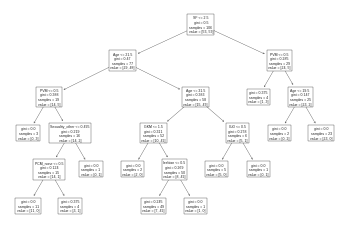

In [321]:
plot_tree(DT2,feature_names=X_test.columns)

In [322]:
feature_impact=pd.DataFrame()
feature_impact['features']=X_test.columns
feature_impact['impact']=DT2.feature_importances_
feature_impact

features    impact
0                             Age  0.385445
1                              IR  0.000000
2                              SA  0.000000
3                              SF  0.225481
4                             PVM  0.183271
5                            PVPM  0.000000
6                              KM  0.000000
7                             GKM  0.071417
8                      Confidence  0.000000
9                    Gender_other  0.000000
10                            Man  0.000000
11      Non-Binary/Non-Conforming  0.000000
12                          Woman  0.000000
13                Sexuality_other  0.042982
14                      aromantic  0.000000
15                        asexuel  0.000000
16                       bisexual  0.000000
17                          fluid  0.000000
18                            gay  0.000000
19                        lesbian  0.037895
20                      pansexual  0.000000
21           prefer not to answer  0.000000
22                          queer  0.000000
23                       straight  0.000000
24                Computing or IT  0.000000
25   Engineering or manufacturing  0.000000
26                      Job_other  0.000000
27                        Student  0.000000
28  Teacher training or education  0.000000
29                       CM_other  0.000000
30                            IUD  0.043860
31                         condom  0.000000
32                           none  0.000000
33                      oral pill  0.000000
34                        PCM_IUD  0.000000
35                     PCM_condom  0.000000
36                       PCM_none  0.009649
37                  PCM_oral pill  0.000000
38                      PCM_other  0.000000

In [323]:
#let find ROC and AUC score
#before we calculate roc_auc_score(), we need to find out the predicted probabilities for test data.
pred_prob = pd.DataFrame(DT2.predict_proba(X_test))
#we'll also add the actual label
test_result=y_test
test_result.columns=['actual']
test_result = test_result.reset_index()
test_result['prob_0'] = pred_prob.iloc[:,0]
test_result['prob_1'] = pred_prob.iloc[:,1]
test_result.head()

index  0    prob_0    prob_1
0     25  1  0.142857  0.857143
1     51  0  1.000000  0.000000
2     21  1  0.142857  0.857143
3     26  1  0.142857  0.857143
4     64  0  1.000000  0.000000

In [324]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(handle_unknown='ignore')
y_train_1 =np.array(y_train).reshape(-1, 1)
enc.fit(y_train_1)
y_test1=pd.DataFrame(enc.transform(np.array(y_test).reshape(-1, 1)).toarray())
y_test1.head()

0    1
0  0.0  1.0
1  1.0  0.0
2  0.0  1.0
3  0.0  1.0
4  1.0  0.0

In [325]:
#accuracy for each class
metrics.roc_auc_score(y_test1,test_result[['prob_0','prob_1']],average=None)

array([0.75457875, 0.75457875])

In [326]:
#Fast way to draw ROC curve and calculate AUC accuarcies of each class
#from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(DT2)
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()    

##### Determine the hyperparameters

In [327]:
DT3=DecisionTreeClassifier()
cv = StratifiedKFold(5)
param_val = [{'criterion':['entropy','gini'],'max_depth':[4,5,6,7,8],'min_samples_split':np.arange(2,10,2)}]
#grid search configuration
grid = GridSearchCV(DT3, param_val, cv = cv,scoring='roc_auc_ovr')
#fitting into our data
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [4, 5, 6, 7, 8],
                          'min_samples_split': array([2, 4, 6, 8])}],
             scoring='roc_auc_ovr')

In [328]:
print(grid.best_score_)
print(grid.best_params_)

0.7087603305785124
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}
